In [1]:
!python --version

Python 3.7.12


In [ ]:
# install Tensorflow version 2.11.0 (latest)
# !pip install --upgrade -q pip
# !pip install --upgrade -q tensorflow==2.11.0

In [2]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [3]:
# Clone the tensorflow models repository if it doesn't already exist
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4411, done.
remote: Counting objects: 100% (4411/4411), done.
remote: Compressing objects: 100% (3227/3227), done.
remote: Total 4411 (delta 1191), reused 3104 (delta 1109), pack-reused 0 (from 0)
Receiving objects: 100% (4411/4411), 70.07 MiB | 41.36 MiB/s, done.
Resolving deltas: 100% (1191/1191), done.


In [4]:
cd /kaggle/working/

/kaggle/working


In [5]:
%%bash
cd /kaggle/working/models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q .

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.12.2 requires cupy-cuda115, which is not installed.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
pathos 0.3.0 requires dill>=0.3.6, but you have dill 0.3.1.1 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
multiprocess 0.70.14 requires dill>=0.3.6, but you have dill 0.3.1.1 which is incompatible.
distributed 2021.11.2 requires dask==2021.11.2, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21

In [6]:
!pip uninstall -y protobuf
!pip install protobuf==3.20.*
# and restart or try 2 times

Found existing installation: protobuf 3.19.6
Uninstalling protobuf-3.19.6:
  Successfully uninstalled protobuf-3.19.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.79.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-serving-api 2.11.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorboardx 2.5.1 requ

In [7]:
#run model builder test
!python /kaggle/working/models/research/object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.12: /opt/conda/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
/opt/conda/lib/python3.7/site-packages/object_detection/builders/model_builder.py:1112: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W0124 08:57:07.522329 139469321664320 model_builder.py:1112] Building experimental DeepMAC meta-arch. Some features may be omitted.
I0124 08:57:07.876817 139469321664320 test_util.py:2458] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 4.94s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
I0124 08:57:08.758156 139469321664320 test_util.py:2458] time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.88s
[       OK ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_

In [14]:
train_record_path = '/kaggle/input/sis-det-tfrecords/train.record'
valid_record_path = '/kaggle/input/sis-det-tfrecords/valid.record'
labelmap_path = '/kaggle/input/sis-det-tfrecords/label_map.pbtxt'

In [18]:
batch_size = 8
num_steps = 11000 # 10700 30 epochs
num_eval_steps = 104
num_classes = 6

In [19]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz
!tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz

--2026-01-24 09:09:52--  http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 192.178.210.207, 74.125.201.207, 142.251.189.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|192.178.210.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1426099846 (1.3G) [application/x-tar]
Saving to: ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz’

centernet_hg104_512 100%[===================>]   1.33G   195MB/s    in 6.9s    

2026-01-24 09:09:59 (198 MB/s) - ‘centernet_hg104_512x512_coco17_tpu-8.tar.gz’ saved [1426099846/1426099846]



In [20]:
fine_tune_checkpoint = '/kaggle/working/centernet_hg104_512x512_coco17_tpu-8/checkpoint/ckpt-0'

In [21]:
base_config_path = '/kaggle/working/centernet_hg104_512x512_coco17_tpu-8/pipeline.config'

In [22]:
# edit configuration file
import re

with open(base_config_path) as f:
    config = f.read()

with open('centernet_hg104.config', 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(valid_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(num_classes), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [23]:
%cat /kaggle/working/centernet_hg104.config

model {
  center_net {
    num_classes: 6
    feature_extractor {
      type: "hourglass_104"
      channel_means: 104.01361846923828
      channel_means: 114.03422546386719
      channel_means: 119.91659545898438
      channel_stds: 73.60276794433594
      channel_stds: 69.89082336425781
      channel_stds: 70.91507720947266
      bgr_ordering: true
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    object_detection_task {
      task_loss_weight: 1.0
      offset_loss_weight: 1.0
      scale_loss_weight: 0.10000000149011612
      localization_loss {
        l1_localization_loss {
        }
      }
    }
    object_center_params {
      object_center_loss_weight: 1.0
      classification_loss {
        penalty_reduced_logistic_focal_loss {
          alpha: 2.0
          beta: 4.0
        }
      }
      min_box_overlap_iou: 0.699999988079071
      max_box_predictions: 100

In [24]:
def get_pipeline_config(path):
    pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
    with tf.io.gfile.GFile(path, 'r') as f:
        text_format.Merge(f.read(), pipeline_config)

    return pipeline_config

def save_pipeline_config(pipeline_config, path):
    config_text = text_format.MessageToString(pipeline_config)
    with tf.io.gfile.GFile(path, "wb") as f:
        f.write(config_text)

In [25]:
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [26]:
pipeline_config_path = '/kaggle/working/centernet_hg104.config'
pipeline_config = get_pipeline_config(pipeline_config_path)

In [27]:
pipeline_config.eval_config.batch_size = 1

In [28]:
# Access the first eval_input_reader in the list using [0]
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [train_record_path]
# Access the first eval_input_reader in the list using [0]
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [valid_record_path]

In [ ]:
# pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.total_steps = 10700
# pipeline_config.train_config.optimizer.momentum_optimizer.learning_rate.cosine_decay_learning_rate.warmup_steps = 1800

In [29]:
save_pipeline_config(pipeline_config, '/kaggle/working/centernet_hg104.config')

In [30]:
%cat /kaggle/working/centernet_hg104.config

model {
  center_net {
    num_classes: 6
    feature_extractor {
      type: "hourglass_104"
      channel_means: 104.01362
      channel_means: 114.034225
      channel_means: 119.916595
      channel_stds: 73.60277
      channel_stds: 69.89082
      channel_stds: 70.91508
      bgr_ordering: true
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    object_detection_task {
      task_loss_weight: 1.0
      offset_loss_weight: 1.0
      scale_loss_weight: 0.1
      localization_loss {
        l1_localization_loss {
        }
      }
    }
    object_center_params {
      object_center_loss_weight: 1.0
      classification_loss {
        penalty_reduced_logistic_focal_loss {
          alpha: 2.0
          beta: 4.0
        }
      }
      min_box_overlap_iou: 0.7
      max_box_predictions: 100
    }
  }
}
train_config {
  batch_size: 8
  data_augmentation_options {
    rand

In [31]:
%%writefile /kaggle/working/centernet_hg104.config
model {
  center_net {
    num_classes: 6
    feature_extractor {
      type: "hourglass_104"
      channel_means: 104.01362
      channel_means: 114.034225
      channel_means: 119.916595
      channel_stds: 73.60277
      channel_stds: 69.89082
      channel_stds: 70.91508
      bgr_ordering: true
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    object_detection_task {
      task_loss_weight: 1.0
      offset_loss_weight: 1.0
      scale_loss_weight: 0.1
      localization_loss {
        l1_localization_loss {
        }
      }
    }
    object_center_params {
      object_center_loss_weight: 1.0
      classification_loss {
        penalty_reduced_logistic_focal_loss {
          alpha: 2.0
          beta: 4.0
        }
      }
      min_box_overlap_iou: 0.7
      max_box_predictions: 100
    }
  }
}
train_config {
  batch_size: 8
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_crop_image {
      min_aspect_ratio: 0.5
      max_aspect_ratio: 1.7
      random_coef: 0.25
    }
  }
  data_augmentation_options {
    random_adjust_hue {
    }
  }
  data_augmentation_options {
    random_adjust_contrast {
    }
  }
  data_augmentation_options {
    random_adjust_saturation {
    }
  }
  data_augmentation_options {
    random_adjust_brightness {
    }
  }
  data_augmentation_options {
    random_absolute_pad_image {
      max_height_padding: 200
      max_width_padding: 200
      pad_color: 0.0
      pad_color: 0.0
      pad_color: 0.0
    }
  }
  optimizer {
    adam_optimizer {
      learning_rate {
        cosine_decay_learning_rate {
          learning_rate_base: 0.001
          total_steps: 250000
          warmup_learning_rate: 0.00025
          warmup_steps: 5000
        }
      }
      epsilon: 1e-07
    }
    use_moving_average: false
  }
  fine_tune_checkpoint: "/kaggle/working/centernet_hg104_512x512_coco17_tpu-8/checkpoint/ckpt-0"
  num_steps: 11000
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  fine_tune_checkpoint_type: "detection"
  fine_tune_checkpoint_version: V2
}
train_input_reader {
  label_map_path: "/kaggle/input/sis-det-tfrecords/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/kaggle/input/sis-det-tfrecords/train.record"
  }
}
eval_config {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1
}
eval_input_reader {
  label_map_path: "/kaggle/input/sis-det-tfrecords/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/kaggle/input/sis-det-tfrecords/valid.record"
  }
}

Overwriting /kaggle/working/centernet_hg104.config


In [32]:
%cat /kaggle/working/centernet_hg104.config

model {
  center_net {
    num_classes: 6
    feature_extractor {
      type: "hourglass_104"
      channel_means: 104.01362
      channel_means: 114.034225
      channel_means: 119.916595
      channel_stds: 73.60277
      channel_stds: 69.89082
      channel_stds: 70.91508
      bgr_ordering: true
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
      }
    }
    object_detection_task {
      task_loss_weight: 1.0
      offset_loss_weight: 1.0
      scale_loss_weight: 0.1
      localization_loss {
        l1_localization_loss {
        }
      }
    }
    object_center_params {
      object_center_loss_weight: 1.0
      classification_loss {
        penalty_reduced_logistic_focal_loss {
          alpha: 2.0
          beta: 4.0
        }
      }
      min_box_overlap_iou: 0.7
      max_box_predictions: 100
    }
  }
}
train_config {
  batch_size: 8
  data_augmentation_options {
    rand

In [ ]:
!rm -r centernet_hg104_training

In [33]:
!mkdir centernet_hg104_training

In [34]:
!cp -r /kaggle/input/centernet-hg104-training/tensorflow2/default/1/kaggle/working/centernet_hg104_training /kaggle/working/centernet_hg104_training

In [44]:
model_dir = '/kaggle/working/centernet_hg104_training/centernet_hg104_training'
pipeline_config_path = '/kaggle/working/centernet_hg104.config'

In [ ]:
'''
I0120 11:52:42.604390 139134185912128 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
I0120 11:52:42.607739 139134185912128 config_util.py:552] Maybe overwriting train_steps: 11000
I0120 11:52:42.607916 139134185912128 config_util.py:552] Maybe overwriting use_bfloat16: False
W0120 11:52:43.213351 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/object_detection/model_lib_v2.py:564: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
I0120 11:52:43.244929 139134185912128 dataset_builder.py:162] Reading unweighted datasets: ['/kaggle/input/sis-det-tfrecords/train.record']
I0120 11:52:43.245200 139134185912128 dataset_builder.py:79] Reading record datasets for input file: ['/kaggle/input/sis-det-tfrecords/train.record']
I0120 11:52:43.245316 139134185912128 dataset_builder.py:80] Number of filenames to read: 1
W0120 11:52:43.245405 139134185912128 dataset_builder.py:87] num_readers has been reduced to 1 to match input file shards.
W0120 11:52:43.252992 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/object_detection/builders/dataset_builder.py:104: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
W0120 11:52:43.416835 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/object_detection/builders/dataset_builder.py:236: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
W0120 11:52:43.932527 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
W0120 11:52:50.664515 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0120 11:52:53.581237 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1176: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W0120 11:52:56.798774 139134185912128 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/opt/conda/lib/python3.7/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  "`tf.keras.backend.set_learning_phase` is deprecated and "
I0120 11:53:45.607311 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.612840 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.614307 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.615680 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.619140 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.624078 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.625595 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.626940 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.630684 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0120 11:53:45.632024 139134185912128 cross_device_ops.py:618] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
W0120 11:53:49.352729 139128968050432 deprecation.py:560] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py:629: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
I0120 11:53:49.647764 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:49.674214 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:49.698420 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:49.837769 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:49.864130 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:49.888831 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:50.019031 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:50.045065 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:50.071310 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 11:53:50.204637 139134185912128 cross_device_ops.py:900] batch_all_reduce: 1 all-reduces with algorithm = nccl, num_packs = 1
I0120 12:04:24.745682 139134185912128 model_lib_v2.py:707] Step 100 per-step time 6.358s
I0120 12:04:24.746140 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5138312,
 'Loss/box/scale': 3.374845,
 'Loss/object_center': 3.6514888,
 'Loss/total_loss': 7.540165,
 'learning_rate': 0.000265}
I0120 12:07:50.617806 139134185912128 model_lib_v2.py:707] Step 200 per-step time 2.059s
I0120 12:07:50.618242 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.54535043,
 'Loss/box/scale': 3.382196,
 'Loss/object_center': 3.4669876,
 'Loss/total_loss': 7.394534,
 'learning_rate': 0.00028}
I0120 12:11:16.096204 139134185912128 model_lib_v2.py:707] Step 300 per-step time 2.055s
I0120 12:11:16.096655 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5334418,
 'Loss/box/scale': 2.5200195,
 'Loss/object_center': 3.2538948,
 'Loss/total_loss': 6.307356,
 'learning_rate': 0.000295}
I0120 12:14:41.386560 139134185912128 model_lib_v2.py:707] Step 400 per-step time 2.053s
I0120 12:14:41.386939 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.49470523,
 'Loss/box/scale': 1.6212282,
 'Loss/object_center': 3.370408,
 'Loss/total_loss': 5.4863415,
 'learning_rate': 0.00031}
I0120 12:18:06.999778 139134185912128 model_lib_v2.py:707] Step 500 per-step time 2.056s
I0120 12:18:07.000161 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5667319,
 'Loss/box/scale': 1.8604854,
 'Loss/object_center': 3.3140502,
 'Loss/total_loss': 5.741267,
 'learning_rate': 0.00032500003}
I0120 12:21:32.184799 139134185912128 model_lib_v2.py:707] Step 600 per-step time 2.052s
I0120 12:21:32.185187 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.673918,
 'Loss/box/scale': 2.0340602,
 'Loss/object_center': 3.1891985,
 'Loss/total_loss': 5.897177,
 'learning_rate': 0.00034000003}
I0120 12:24:57.420240 139134185912128 model_lib_v2.py:707] Step 700 per-step time 2.052s
I0120 12:24:57.420640 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.56394815,
 'Loss/box/scale': 1.602044,
 'Loss/object_center': 3.0118136,
 'Loss/total_loss': 5.177806,
 'learning_rate': 0.00035500003}
I0120 12:28:22.783792 139134185912128 model_lib_v2.py:707] Step 800 per-step time 2.054s
I0120 12:28:22.784200 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.6553971,
 'Loss/box/scale': 1.5884814,
 'Loss/object_center': 3.2190402,
 'Loss/total_loss': 5.4629183,
 'learning_rate': 0.00037000002}
I0120 12:31:47.635677 139134185912128 model_lib_v2.py:707] Step 900 per-step time 2.049s
I0120 12:31:47.636040 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.40558016,
 'Loss/box/scale': 1.8295665,
 'Loss/object_center': 3.0287867,
 'Loss/total_loss': 5.263933,
 'learning_rate': 0.00038500002}
I0120 12:35:12.143406 139134185912128 model_lib_v2.py:707] Step 1000 per-step time 2.045s
I0120 12:35:12.143765 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5430805,
 'Loss/box/scale': 1.3438972,
 'Loss/object_center': 2.891024,
 'Loss/total_loss': 4.778002,
 'learning_rate': 0.00040000002}
I0120 12:38:45.228115 139134185912128 model_lib_v2.py:707] Step 1100 per-step time 2.131s
I0120 12:38:45.228571 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.48936403,
 'Loss/box/scale': 2.0194132,
 'Loss/object_center': 3.345962,
 'Loss/total_loss': 5.854739,
 'learning_rate': 0.00041500002}
I0120 12:42:09.289220 139134185912128 model_lib_v2.py:707] Step 1200 per-step time 2.041s
I0120 12:42:09.289583 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5133451,
 'Loss/box/scale': 2.0267704,
 'Loss/object_center': 2.904152,
 'Loss/total_loss': 5.4442673,
 'learning_rate': 0.00043000001}
I0120 12:45:33.653457 139134185912128 model_lib_v2.py:707] Step 1300 per-step time 2.044s
I0120 12:45:33.653803 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5557534,
 'Loss/box/scale': 1.4790479,
 'Loss/object_center': 3.1830192,
 'Loss/total_loss': 5.2178206,
 'learning_rate': 0.000445}
I0120 12:48:57.925082 139134185912128 model_lib_v2.py:707] Step 1400 per-step time 2.043s
I0120 12:48:57.925471 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4423756,
 'Loss/box/scale': 1.1818179,
 'Loss/object_center': 2.6338716,
 'Loss/total_loss': 4.2580647,
 'learning_rate': 0.00046}
I0120 12:52:22.482403 139134185912128 model_lib_v2.py:707] Step 1500 per-step time 2.046s
I0120 12:52:22.482788 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.48314264,
 'Loss/box/scale': 1.6629523,
 'Loss/object_center': 3.1339676,
 'Loss/total_loss': 5.2800627,
 'learning_rate': 0.000475}
I0120 12:55:46.423760 139134185912128 model_lib_v2.py:707] Step 1600 per-step time 2.039s
I0120 12:55:46.424120 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.41026402,
 'Loss/box/scale': 1.6070006,
 'Loss/object_center': 2.8917592,
 'Loss/total_loss': 4.909024,
 'learning_rate': 0.00049}
I0120 12:59:10.699147 139134185912128 model_lib_v2.py:707] Step 1700 per-step time 2.043s
I0120 12:59:10.699509 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4755747,
 'Loss/box/scale': 1.0131507,
 'Loss/object_center': 3.2269816,
 'Loss/total_loss': 4.7157073,
 'learning_rate': 0.000505}
I0120 13:02:34.962692 139134185912128 model_lib_v2.py:707] Step 1800 per-step time 2.043s
I0120 13:02:34.963063 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.46534717,
 'Loss/box/scale': 1.0533204,
 'Loss/object_center': 2.7977896,
 'Loss/total_loss': 4.316457,
 'learning_rate': 0.00052}
I0120 13:05:58.834286 139134185912128 model_lib_v2.py:707] Step 1900 per-step time 2.039s
I0120 13:05:58.834625 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.44702077,
 'Loss/box/scale': 1.4399977,
 'Loss/object_center': 2.7162428,
 'Loss/total_loss': 4.6032615,
 'learning_rate': 0.000535}
I0120 13:09:23.136879 139134185912128 model_lib_v2.py:707] Step 2000 per-step time 2.043s
I0120 13:09:23.137207 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.3784256,
 'Loss/box/scale': 1.7845736,
 'Loss/object_center': 2.8029933,
 'Loss/total_loss': 4.9659925,
 'learning_rate': 0.00055}
I0120 13:12:55.112815 139134185912128 model_lib_v2.py:707] Step 2100 per-step time 2.118s
I0120 13:12:55.113148 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4325429,
 'Loss/box/scale': 1.2774086,
 'Loss/object_center': 2.8761113,
 'Loss/total_loss': 4.586063,
 'learning_rate': 0.000565}
I0120 13:16:19.526107 139134185912128 model_lib_v2.py:707] Step 2200 per-step time 2.045s
I0120 13:16:19.526455 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.54695284,
 'Loss/box/scale': 0.7160188,
 'Loss/object_center': 2.8020308,
 'Loss/total_loss': 4.0650024,
 'learning_rate': 0.00058}
I0120 13:19:43.980349 139134185912128 model_lib_v2.py:707] Step 2300 per-step time 2.045s
I0120 13:19:43.980724 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.62316,
 'Loss/box/scale': 1.6780735,
 'Loss/object_center': 3.122808,
 'Loss/total_loss': 5.4240417,
 'learning_rate': 0.000595}
I0120 13:23:08.259809 139134185912128 model_lib_v2.py:707] Step 2400 per-step time 2.043s
I0120 13:23:08.260151 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.70339805,
 'Loss/box/scale': 2.2019203,
 'Loss/object_center': 2.9108458,
 'Loss/total_loss': 5.816164,
 'learning_rate': 0.00061}
I0120 13:26:32.491509 139134185912128 model_lib_v2.py:707] Step 2500 per-step time 2.042s
I0120 13:26:32.491853 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5058435,
 'Loss/box/scale': 1.3906599,
 'Loss/object_center': 2.8536556,
 'Loss/total_loss': 4.7501593,
 'learning_rate': 0.000625}
I0120 13:29:56.412304 139134185912128 model_lib_v2.py:707] Step 2600 per-step time 2.039s
I0120 13:29:56.412672 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5012561,
 'Loss/box/scale': 1.2361218,
 'Loss/object_center': 2.7187438,
 'Loss/total_loss': 4.4561214,
 'learning_rate': 0.00064}
I0120 13:33:20.669777 139134185912128 model_lib_v2.py:707] Step 2700 per-step time 2.043s
I0120 13:33:20.670113 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.31706154,
 'Loss/box/scale': 2.0364969,
 'Loss/object_center': 2.5207474,
 'Loss/total_loss': 4.874306,
 'learning_rate': 0.00065500004}
I0120 13:36:45.077623 139134185912128 model_lib_v2.py:707] Step 2800 per-step time 2.044s
I0120 13:36:45.077969 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.47207564,
 'Loss/box/scale': 0.7987124,
 'Loss/object_center': 2.6581018,
 'Loss/total_loss': 3.9288898,
 'learning_rate': 0.00067000004}
I0120 13:40:09.433563 139134185912128 model_lib_v2.py:707] Step 2900 per-step time 2.044s
I0120 13:40:09.433877 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.563941,
 'Loss/box/scale': 1.2054431,
 'Loss/object_center': 2.6816912,
 'Loss/total_loss': 4.4510756,
 'learning_rate': 0.00068500004}
I0120 13:43:33.360331 139134185912128 model_lib_v2.py:707] Step 3000 per-step time 2.039s
I0120 13:43:33.360809 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.47681877,
 'Loss/box/scale': 1.1427629,
 'Loss/object_center': 2.5429983,
 'Loss/total_loss': 4.16258,
 'learning_rate': 0.00070000003}
I0120 13:47:05.485387 139134185912128 model_lib_v2.py:707] Step 3100 per-step time 2.121s
I0120 13:47:05.485872 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.46005565,
 'Loss/box/scale': 1.799064,
 'Loss/object_center': 3.188515,
 'Loss/total_loss': 5.4476347,
 'learning_rate': 0.00071500003}
I0120 13:50:29.636765 139134185912128 model_lib_v2.py:707] Step 3200 per-step time 2.042s
I0120 13:50:29.637122 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4967652,
 'Loss/box/scale': 2.154131,
 'Loss/object_center': 3.221334,
 'Loss/total_loss': 5.8722305,
 'learning_rate': 0.00073}
I0120 13:53:53.737233 139134185912128 model_lib_v2.py:707] Step 3300 per-step time 2.041s
I0120 13:53:53.737569 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4886136,
 'Loss/box/scale': 1.5090401,
 'Loss/object_center': 2.5605907,
 'Loss/total_loss': 4.558244,
 'learning_rate': 0.0007450001}
I0120 13:57:17.893633 139134185912128 model_lib_v2.py:707] Step 3400 per-step time 2.042s
I0120 13:57:17.894002 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.53493893,
 'Loss/box/scale': 1.7111968,
 'Loss/object_center': 2.7240279,
 'Loss/total_loss': 4.970164,
 'learning_rate': 0.0007600001}
I0120 14:00:42.016344 139134185912128 model_lib_v2.py:707] Step 3500 per-step time 2.041s
I0120 14:00:42.016712 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.44847035,
 'Loss/box/scale': 1.6288326,
 'Loss/object_center': 2.9166925,
 'Loss/total_loss': 4.993995,
 'learning_rate': 0.0007750001}
I0120 14:04:06.026026 139134185912128 model_lib_v2.py:707] Step 3600 per-step time 2.040s
I0120 14:04:06.026393 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5255017,
 'Loss/box/scale': 1.5045139,
 'Loss/object_center': 3.2378163,
 'Loss/total_loss': 5.267832,
 'learning_rate': 0.0007900001}
I0120 14:07:30.237253 139134185912128 model_lib_v2.py:707] Step 3700 per-step time 2.042s
I0120 14:07:30.237635 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5840097,
 'Loss/box/scale': 1.701519,
 'Loss/object_center': 2.549598,
 'Loss/total_loss': 4.835127,
 'learning_rate': 0.0008050001}
I0120 14:10:54.386697 139134185912128 model_lib_v2.py:707] Step 3800 per-step time 2.041s
I0120 14:10:54.387043 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.48701844,
 'Loss/box/scale': 1.3052483,
 'Loss/object_center': 2.7007403,
 'Loss/total_loss': 4.4930067,
 'learning_rate': 0.0008200001}
I0120 14:14:18.743551 139134185912128 model_lib_v2.py:707] Step 3900 per-step time 2.044s
I0120 14:14:18.743883 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.47741503,
 'Loss/box/scale': 1.2920076,
 'Loss/object_center': 2.9717736,
 'Loss/total_loss': 4.741196,
 'learning_rate': 0.0008350001}
I0120 14:17:42.851736 139134185912128 model_lib_v2.py:707] Step 4000 per-step time 2.041s
I0120 14:17:42.852075 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.47349826,
 'Loss/box/scale': 1.1038171,
 'Loss/object_center': 2.4038615,
 'Loss/total_loss': 3.9811769,
 'learning_rate': 0.00085000007}
I0120 14:21:15.596331 139134185912128 model_lib_v2.py:707] Step 4100 per-step time 2.127s
I0120 14:21:15.596711 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.41642484,
 'Loss/box/scale': 1.5435808,
 'Loss/object_center': 2.6989083,
 'Loss/total_loss': 4.658914,
 'learning_rate': 0.00086500007}
I0120 14:24:39.382441 139134185912128 model_lib_v2.py:707] Step 4200 per-step time 2.038s
I0120 14:24:39.382768 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.50369686,
 'Loss/box/scale': 1.5467856,
 'Loss/object_center': 2.4426377,
 'Loss/total_loss': 4.49312,
 'learning_rate': 0.00088000007}
I0120 14:28:03.878925 139134185912128 model_lib_v2.py:707] Step 4300 per-step time 2.045s
I0120 14:28:03.879276 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.45524883,
 'Loss/box/scale': 1.7035196,
 'Loss/object_center': 2.5606415,
 'Loss/total_loss': 4.71941,
 'learning_rate': 0.00089500006}
I0120 14:31:27.875280 139134185912128 model_lib_v2.py:707] Step 4400 per-step time 2.040s
I0120 14:31:27.875624 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.46531028,
 'Loss/box/scale': 1.431802,
 'Loss/object_center': 3.0710087,
 'Loss/total_loss': 4.968121,
 'learning_rate': 0.00091000006}
I0120 14:34:52.363455 139134185912128 model_lib_v2.py:707] Step 4500 per-step time 2.045s
I0120 14:34:52.363815 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.63826716,
 'Loss/box/scale': 1.5487559,
 'Loss/object_center': 2.7569985,
 'Loss/total_loss': 4.9440217,
 'learning_rate': 0.00092500006}
I0120 14:38:16.823160 139134185912128 model_lib_v2.py:707] Step 4600 per-step time 2.045s
I0120 14:38:16.823571 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5327852,
 'Loss/box/scale': 1.8621662,
 'Loss/object_center': 2.9173214,
 'Loss/total_loss': 5.312273,
 'learning_rate': 0.00094000006}
I0120 14:41:41.125482 139134185912128 model_lib_v2.py:707] Step 4700 per-step time 2.043s
I0120 14:41:41.125834 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4612156,
 'Loss/box/scale': 1.2642899,
 'Loss/object_center': 2.6471565,
 'Loss/total_loss': 4.372662,
 'learning_rate': 0.00095500005}
I0120 14:45:05.129945 139134185912128 model_lib_v2.py:707] Step 4800 per-step time 2.040s
I0120 14:45:05.130298 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.50495636,
 'Loss/box/scale': 1.8023604,
 'Loss/object_center': 3.0845191,
 'Loss/total_loss': 5.391836,
 'learning_rate': 0.00097000005}
I0120 14:48:29.231905 139134185912128 model_lib_v2.py:707] Step 4900 per-step time 2.041s
I0120 14:48:29.232252 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.46831703,
 'Loss/box/scale': 1.0950058,
 'Loss/object_center': 2.6144578,
 'Loss/total_loss': 4.1777806,
 'learning_rate': 0.000985}
I0120 14:51:53.543452 139134185912128 model_lib_v2.py:707] Step 5000 per-step time 2.043s
I0120 14:51:53.543817 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.42001036,
 'Loss/box/scale': 1.7210602,
 'Loss/object_center': 2.901005,
 'Loss/total_loss': 5.042075,
 'learning_rate': 0.001}
I0120 14:55:25.828055 139134185912128 model_lib_v2.py:707] Step 5100 per-step time 2.123s
I0120 14:55:25.828396 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.5962373,
 'Loss/box/scale': 2.100171,
 'Loss/object_center': 2.5475054,
 'Loss/total_loss': 5.2439137,
 'learning_rate': 0.0009999996}
I0120 14:58:50.062556 139134185912128 model_lib_v2.py:707] Step 5200 per-step time 2.042s
I0120 14:58:50.062914 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.45436138,
 'Loss/box/scale': 1.7834096,
 'Loss/object_center': 2.7039278,
 'Loss/total_loss': 4.941699,
 'learning_rate': 0.0009999984}
I0120 15:02:13.799371 139134185912128 model_lib_v2.py:707] Step 5300 per-step time 2.037s
I0120 15:02:13.799760 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.32587835,
 'Loss/box/scale': 2.2714179,
 'Loss/object_center': 2.4409938,
 'Loss/total_loss': 5.03829,
 'learning_rate': 0.0009999963}
I0120 15:05:37.291345 139134185912128 model_lib_v2.py:707] Step 5400 per-step time 2.035s
I0120 15:05:37.291740 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.48873538,
 'Loss/box/scale': 1.2888972,
 'Loss/object_center': 2.930747,
 'Loss/total_loss': 4.7083797,
 'learning_rate': 0.0009999935}
I0120 15:09:01.156710 139134185912128 model_lib_v2.py:707] Step 5500 per-step time 2.039s
I0120 15:09:01.157048 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.38898647,
 'Loss/box/scale': 1.4389303,
 'Loss/object_center': 2.5415468,
 'Loss/total_loss': 4.3694634,
 'learning_rate': 0.0009999898}
I0120 15:12:25.514376 139134185912128 model_lib_v2.py:707] Step 5600 per-step time 2.044s
I0120 15:12:25.514758 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.49817228,
 'Loss/box/scale': 1.3078092,
 'Loss/object_center': 2.8437352,
 'Loss/total_loss': 4.6497164,
 'learning_rate': 0.0009999853}
I0120 15:15:49.302265 139134185912128 model_lib_v2.py:707] Step 5700 per-step time 2.038s
I0120 15:15:49.302648 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.43764514,
 'Loss/box/scale': 1.1237223,
 'Loss/object_center': 2.7058442,
 'Loss/total_loss': 4.267212,
 'learning_rate': 0.0009999799}
I0120 15:19:13.601712 139134185912128 model_lib_v2.py:707] Step 5800 per-step time 2.043s
I0120 15:19:13.602062 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.43032512,
 'Loss/box/scale': 1.143379,
 'Loss/object_center': 2.0627077,
 'Loss/total_loss': 3.6364114,
 'learning_rate': 0.0009999737}
I0120 15:22:37.299930 139134185912128 model_lib_v2.py:707] Step 5900 per-step time 2.037s
I0120 15:22:37.300284 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.49184486,
 'Loss/box/scale': 1.4483929,
 'Loss/object_center': 2.8668392,
 'Loss/total_loss': 4.8070765,
 'learning_rate': 0.0009999668}
I0120 15:26:01.358555 139134185912128 model_lib_v2.py:707] Step 6000 per-step time 2.041s
I0120 15:26:01.358925 139134185912128 model_lib_v2.py:708] {'Loss/box/offset': 0.4059556,
 'Loss/box/scale': 1.6996224,
 'Loss/object_center': 2.9590127,
 'Loss/total_loss': 5.064591,
 'learning_rate': 0.000999959}
^C
I0124 09:56:32.659125 139762667362112 model_lib_v2.py:707] Step 6100 per-step time 6.058s
I0124 09:56:32.659547 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.5408743,
 'Loss/box/scale': 1.4579148,
 'Loss/object_center': 3.004726,
 'Loss/total_loss': 5.0035152,
 'learning_rate': 0.0009999503}
I0124 09:59:54.259517 139762667362112 model_lib_v2.py:707] Step 6200 per-step time 2.016s
I0124 09:59:54.259905 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.34292674,
 'Loss/box/scale': 1.6178397,
 'Loss/object_center': 2.5409672,
 'Loss/total_loss': 4.501734,
 'learning_rate': 0.0009999409}
I0124 10:03:15.408708 139762667362112 model_lib_v2.py:707] Step 6300 per-step time 2.012s
I0124 10:03:15.409060 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.5692457,
 'Loss/box/scale': 1.4349469,
 'Loss/object_center': 2.9233928,
 'Loss/total_loss': 4.9275856,
 'learning_rate': 0.0009999305}
I0124 10:06:36.743316 139762667362112 model_lib_v2.py:707] Step 6400 per-step time 2.013s
I0124 10:06:36.743689 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.41393018,
 'Loss/box/scale': 1.261375,
 'Loss/object_center': 2.500661,
 'Loss/total_loss': 4.1759663,
 'learning_rate': 0.0009999195}
I0124 10:09:58.105095 139762667362112 model_lib_v2.py:707] Step 6500 per-step time 2.014s
I0124 10:09:58.105504 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.44621867,
 'Loss/box/scale': 1.926454,
 'Loss/object_center': 2.65751,
 'Loss/total_loss': 5.030183,
 'learning_rate': 0.0009999075}
I0124 10:13:19.336020 139762667362112 model_lib_v2.py:707] Step 6600 per-step time 2.012s
I0124 10:13:19.336391 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.49961627,
 'Loss/box/scale': 2.1656768,
 'Loss/object_center': 2.9623423,
 'Loss/total_loss': 5.627635,
 'learning_rate': 0.0009998948}
I0124 10:16:40.287350 139762667362112 model_lib_v2.py:707] Step 6700 per-step time 2.010s
I0124 10:16:40.287736 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.567884,
 'Loss/box/scale': 1.1592447,
 'Loss/object_center': 2.3742704,
 'Loss/total_loss': 4.101399,
 'learning_rate': 0.0009998813}
I0124 10:20:01.745641 139762667362112 model_lib_v2.py:707] Step 6800 per-step time 2.015s
I0124 10:20:01.746044 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.44143438,
 'Loss/box/scale': 2.0418465,
 'Loss/object_center': 2.015813,
 'Loss/total_loss': 4.499094,
 'learning_rate': 0.0009998669}
I0124 10:23:23.042815 139762667362112 model_lib_v2.py:707] Step 6900 per-step time 2.013s
I0124 10:23:23.043168 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.3996368,
 'Loss/box/scale': 1.2038462,
 'Loss/object_center': 2.8144858,
 'Loss/total_loss': 4.4179688,
 'learning_rate': 0.0009998516}
I0124 10:26:44.177851 139762667362112 model_lib_v2.py:707] Step 7000 per-step time 2.011s
I0124 10:26:44.178190 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.48437256,
 'Loss/box/scale': 1.6234455,
 'Loss/object_center': 2.6177824,
 'Loss/total_loss': 4.7256002,
 'learning_rate': 0.0009998357}
I0124 10:30:12.737293 139762667362112 model_lib_v2.py:707] Step 7100 per-step time 2.086s
I0124 10:30:12.737686 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.5188323,
 'Loss/box/scale': 1.0469246,
 'Loss/object_center': 2.730844,
 'Loss/total_loss': 4.296601,
 'learning_rate': 0.0009998188}
I0124 10:33:33.825672 139762667362112 model_lib_v2.py:707] Step 7200 per-step time 2.011s
I0124 10:33:33.826201 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.44195622,
 'Loss/box/scale': 1.4594307,
 'Loss/object_center': 2.628922,
 'Loss/total_loss': 4.5303087,
 'learning_rate': 0.0009998011}
I0124 10:36:54.453343 139762667362112 model_lib_v2.py:707] Step 7300 per-step time 2.006s
I0124 10:36:54.453730 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.44926196,
 'Loss/box/scale': 1.6475301,
 'Loss/object_center': 2.3235621,
 'Loss/total_loss': 4.420354,
 'learning_rate': 0.0009997826}
I0124 10:40:15.752099 139762667362112 model_lib_v2.py:707] Step 7400 per-step time 2.013s
I0124 10:40:15.752516 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.43494812,
 'Loss/box/scale': 1.0951275,
 'Loss/object_center': 2.539154,
 'Loss/total_loss': 4.0692296,
 'learning_rate': 0.0009997633}
I0124 10:43:36.311368 139762667362112 model_lib_v2.py:707] Step 7500 per-step time 2.006s
I0124 10:43:36.311765 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.4408896,
 'Loss/box/scale': 1.3517326,
 'Loss/object_center': 2.4360654,
 'Loss/total_loss': 4.228688,
 'learning_rate': 0.0009997431}
I0124 10:46:56.389127 139762667362112 model_lib_v2.py:707] Step 7600 per-step time 2.001s
I0124 10:46:56.389520 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.36944884,
 'Loss/box/scale': 1.4075572,
 'Loss/object_center': 2.1458642,
 'Loss/total_loss': 3.9228702,
 'learning_rate': 0.0009997222}
I0124 10:50:16.865765 139762667362112 model_lib_v2.py:707] Step 7700 per-step time 2.005s
I0124 10:50:16.866115 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.60145897,
 'Loss/box/scale': 1.549641,
 'Loss/object_center': 2.3635354,
 'Loss/total_loss': 4.5146356,
 'learning_rate': 0.0009997004}
I0124 10:53:37.385965 139762667362112 model_lib_v2.py:707] Step 7800 per-step time 2.005s
I0124 10:53:37.386327 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.49027365,
 'Loss/box/scale': 1.4769758,
 'Loss/object_center': 2.6486301,
 'Loss/total_loss': 4.6158795,
 'learning_rate': 0.0009996778}
I0124 10:56:57.528611 139762667362112 model_lib_v2.py:707] Step 7900 per-step time 2.001s
I0124 10:56:57.528970 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.33373207,
 'Loss/box/scale': 1.3456419,
 'Loss/object_center': 2.4223082,
 'Loss/total_loss': 4.101682,
 'learning_rate': 0.0009996543}
I0124 11:00:18.227121 139762667362112 model_lib_v2.py:707] Step 8000 per-step time 2.007s
I0124 11:00:18.227576 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.4825408,
 'Loss/box/scale': 1.4340494,
 'Loss/object_center': 2.1536622,
 'Loss/total_loss': 4.0702524,
 'learning_rate': 0.0009996302}
I0124 11:03:46.426721 139762667362112 model_lib_v2.py:707] Step 8100 per-step time 2.082s
I0124 11:03:46.427107 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.4599209,
 'Loss/box/scale': 1.1332792,
 'Loss/object_center': 2.7816257,
 'Loss/total_loss': 4.3748255,
 'learning_rate': 0.000999605}
I0124 11:07:06.775879 139762667362112 model_lib_v2.py:707] Step 8200 per-step time 2.003s
I0124 11:07:06.776231 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.45939726,
 'Loss/box/scale': 1.4214913,
 'Loss/object_center': 2.609179,
 'Loss/total_loss': 4.4900675,
 'learning_rate': 0.0009995792}
I0124 11:10:27.044238 139762667362112 model_lib_v2.py:707] Step 8300 per-step time 2.003s
I0124 11:10:27.044644 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.60889614,
 'Loss/box/scale': 1.355954,
 'Loss/object_center': 2.8220174,
 'Loss/total_loss': 4.7868676,
 'learning_rate': 0.0009995524}
I0124 11:13:47.660607 139762667362112 model_lib_v2.py:707] Step 8400 per-step time 2.006s
I0124 11:13:47.660979 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.43172383,
 'Loss/box/scale': 1.2121155,
 'Loss/object_center': 2.896624,
 'Loss/total_loss': 4.5404634,
 'learning_rate': 0.000999525}
I0124 11:17:07.819154 139762667362112 model_lib_v2.py:707] Step 8500 per-step time 2.002s
I0124 11:17:07.819589 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.443644,
 'Loss/box/scale': 2.0436647,
 'Loss/object_center': 2.235799,
 'Loss/total_loss': 4.723108,
 'learning_rate': 0.0009994966}
I0124 11:20:28.310931 139762667362112 model_lib_v2.py:707] Step 8600 per-step time 2.005s
I0124 11:20:28.311273 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.51251256,
 'Loss/box/scale': 1.2169868,
 'Loss/object_center': 2.4424093,
 'Loss/total_loss': 4.1719084,
 'learning_rate': 0.0009994674}
I0124 11:23:48.887515 139762667362112 model_lib_v2.py:707] Step 8700 per-step time 2.006s
I0124 11:23:48.887887 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.5256902,
 'Loss/box/scale': 1.526176,
 'Loss/object_center': 2.0817904,
 'Loss/total_loss': 4.1336565,
 'learning_rate': 0.0009994374}
I0124 11:27:09.397171 139762667362112 model_lib_v2.py:707] Step 8800 per-step time 2.005s
I0124 11:27:09.397557 139762667362112 model_lib_v2.py:708] {'Loss/box/offset': 0.46925262,
 'Loss/box/scale': 0.964114,
 'Loss/object_center': 2.2651553,
 'Loss/total_loss': 3.698522,
 'learning_rate': 0.0009994067}
'''

In [46]:
!python /kaggle/working/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

I0124 12:21:03.661574 139596276488000 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
I0124 12:21:03.664622 139596276488000 config_util.py:552] Maybe overwriting train_steps: 11000
I0124 12:21:03.664785 139596276488000 config_util.py:552] Maybe overwriting use_bfloat16: False
W0124 12:21:04.263489 139596276488000 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/object_detection/model_lib_v2.py:564: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
I0124 12:21:04.283083 139596276488000 dataset_builder.py:162] Reading unweighted datasets: ['/kaggle/input/sis-det-tfrecords/train.record']
I0124 12:21:04.283316 139596276488000 dataset_builder.py:79] Reading record datasets for input 

In [91]:
!ls /kaggle/working/centernet_hg104_training/centernet_hg104_training

checkpoint  ckpt-13.data-00000-of-00001  ckpt-13.index	train


In [ ]:
!rm /kaggle/working/centernet_hg104_training/centernet_hg104_training/ckpt-12.index

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '/kaggle/working/centernet_resnet101_training/train'

In [48]:
!mkdir centernet_hg104_inference_graph

In [49]:
output_directory = '/kaggle/working/centernet_hg104_inference_graph'

!python /kaggle/working/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

W0124 13:06:22.642549 135201787524928 deprecation.py:356] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/pyct/static_analysis/liveness.py:83: Analyzer.lamba_check (from tensorflow.python.autograph.pyct.static_analysis.liveness) is deprecated and will be removed after 2023-09-23.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
W0124 13:06:22.722939 135201787524928 deprecation.py:628] From /opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:458: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.

In [ ]:
# can download(f'/kaggle/working/centernet_hg104_inference_graph/saved_model/saved_model.pb') 

In [50]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [51]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [56]:
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [57]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'/kaggle/working/centernet_hg104_inference_graph/saved_model')

In [59]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [61]:
# a = 0
# for image_path in glob.glob('/kaggle/input/sis-det-val/valid/*.jpg'):
#   image_np = load_image_into_numpy_array(image_path)
#   output_dict = run_inference_for_single_image(model, image_np)
#   vis_util.visualize_boxes_and_labels_on_image_array(
#       image_np,
#       output_dict['detection_boxes'],
#       output_dict['detection_classes'],
#       output_dict['detection_scores'],
#       category_index,
#       instance_masks=output_dict.get('detection_masks_reframed', None),
#       use_normalized_coordinates=True,
#       max_boxes_to_draw=20,
#       min_score_thresh=0.3,
#       line_thickness=8)
#   display(Image.fromarray(image_np))
#   a += 1
#   if a == 10:
#       break

In [ ]:
!zip -r /kaggle/working/centernet_hg104_training.zip /kaggle/working/centernet_hg104_training

In [ ]:
!zip -r /kaggle/working/centernet_hg104_TFODfiles.zip /kaggle/working/

In [ ]:
!rm /kaggle/working/centernet_hg104_TFODfiles.zip

In [62]:
# Convert to TFLite. This form of quantization is called
# post-training dynamic-range quantization in TFLite.
converter = tf.lite.TFLiteConverter.from_saved_model("/kaggle/working/centernet_hg104_inference_graph/saved_model")

# Enable TF Select ops for unsupported operations
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS # Enable TF Select ops
]

# No optimizations
tflite_model = converter.convert()
open("SIS_TFOD_CenterNet_hg104.tflite", "wb").write(tflite_model)

757968692

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 4 nodes delegated out of 399 nodes with 2 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite outputs types and shapes:
  Output type=<class 'numpy.ndarray'>, shape=(1,)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 6)
TFLite outputs types and shapes:
  Output type=<class 'numpy.ndarray'>, shape=(1,)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 6)
TFLite outputs types and shapes:
  Output type=<class 'numpy.ndarray'>, shape=(1,)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100)
  Output type=<class 'numpy.ndarray'>, shape=(1, 100, 4)
  Output type=<class 'num

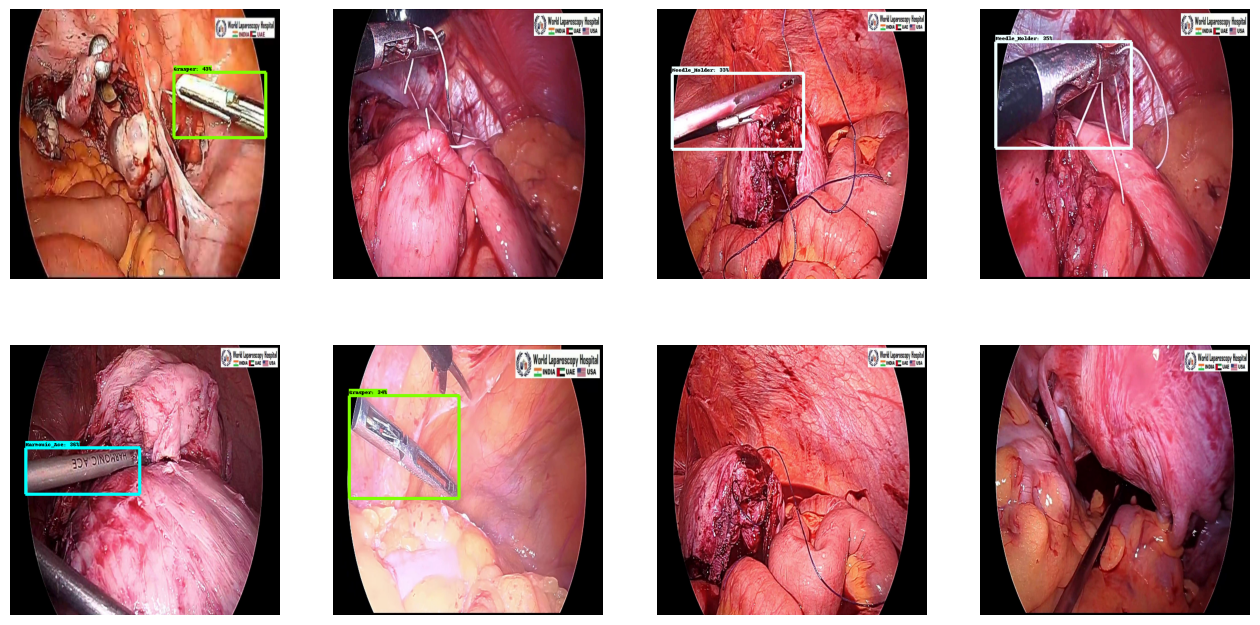

In [63]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/kaggle/input/sis-det-val/valid"

min_score_thresh = 0.3
# visualization layout
N = 8
cols = 4
rows = int(np.ceil(N / cols))

# ---- MODEL DIMENSIONS FOR TFLITE INFERENCE ----
MODEL_H = 512   # TFLite model input height
MODEL_W = 512   # TFLite model input width

# ---------- LOAD TFLITE ----------
interpreter = tf.lite.Interpreter(
    model_path="/kaggle/working/SIS_TFOD_CenterNet_hg104.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ---- FIX MODEL INPUT SHAPE (ONCE) ----
interpreter.resize_tensor_input(
    input_details[0]["index"],
    [1, MODEL_H, MODEL_W, 3],
    strict=True
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, image in enumerate(raw_images):
    plt.subplot(2, 4, i+1)
    input_image = cv2.resize(image, (512, 512))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    image_np = input_image.copy()
    # input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    input_data = (input_image).astype(np.uint8)
    interpreter.set_tensor(input_details[0]["index"], input_data)

    # run inference
    interpreter.invoke()

    # get outputs
    tflite_outputs = []
    print("TFLite outputs types and shapes:")
    for out_detail in output_details:
        output_tensor = interpreter.get_tensor(out_detail["index"])
        tflite_outputs.append(output_tensor)
        print(f"  Output type={type(output_tensor)}, shape={output_tensor.shape}")

    scores = tflite_outputs[4][0]  
    classes = tflite_outputs[2][0].astype(int)   
    boxes   = tflite_outputs[1][0]

    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        category_index=category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=20,
        min_score_thresh=min_score_thresh,
        agnostic_mode=False,
        instance_masks=None,
        line_thickness=6)
    plt.imshow(image_np)
    plt.axis('off')

plt.show()

In [67]:
def class_wise_nms_centernet(
    boxes,
    classes,
    scores,
    score_thresh=0.5,
    iou_thresh=0.45,
    max_detections_per_class=20
):
    final_boxes, final_classes, final_scores = [], [], []

    unique_classes = np.unique(classes)

    for cls in unique_classes:
        if cls < 0:
            continue

        cls_mask = (classes == cls) & (scores >= score_thresh)
        if not np.any(cls_mask):
            continue

        cls_boxes = boxes[cls_mask]
        cls_scores = scores[cls_mask]

        selected = tf.image.non_max_suppression(
            cls_boxes,
            cls_scores,
            max_output_size=max_detections_per_class,
            iou_threshold=iou_thresh
        ).numpy()

        final_boxes.append(cls_boxes[selected])
        final_scores.append(cls_scores[selected])
        final_classes.append(
            np.full(len(selected), cls, dtype=np.int32)
        )

    if not final_boxes:
        return (
            np.empty((0, 4)),
            np.empty((0,), dtype=np.int32),
            np.empty((0,))
        )

    return (
        np.concatenate(final_boxes),
        np.concatenate(final_classes),
        np.concatenate(final_scores)
    )

In [70]:
def global_nms(
    boxes, classes, scores,
    iou_thresh=0.5,
    max_detections=50
):
    selected = tf.image.non_max_suppression(
        boxes,
        scores,
        max_output_size=max_detections,
        iou_threshold=iou_thresh
    ).numpy()

    return (
        boxes[selected],
        classes[selected],
        scores[selected]
    )

In [73]:
def draw_labels_cv2(image, boxes, classes, scores, category_index,
                    font_scale=0.9, thickness=2):
    h, w, _ = image.shape

    for box, cls, score in zip(boxes, classes, scores):
        ymin, xmin, ymax, xmax = box
        x1, y1 = int(xmin * w), int(ymin * h)
        x2, y2 = int(xmax * w), int(ymax * h)

        if cls == 0 or cls not in category_index:
            continue

        label = f"{category_index[cls]['name']}: {score:.2f}"

        (tw, th), _ = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX,
            font_scale, thickness
        )

        cv2.rectangle(image,
                      (x1, y1 - th - 6),
                      (x1 + tw + 4, y1),
                      (0, 0, 0), -1)

        cv2.putText(
            image, label,
            (x1 + 2, y1 - 4),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            thickness,
            cv2.LINE_AA
        )

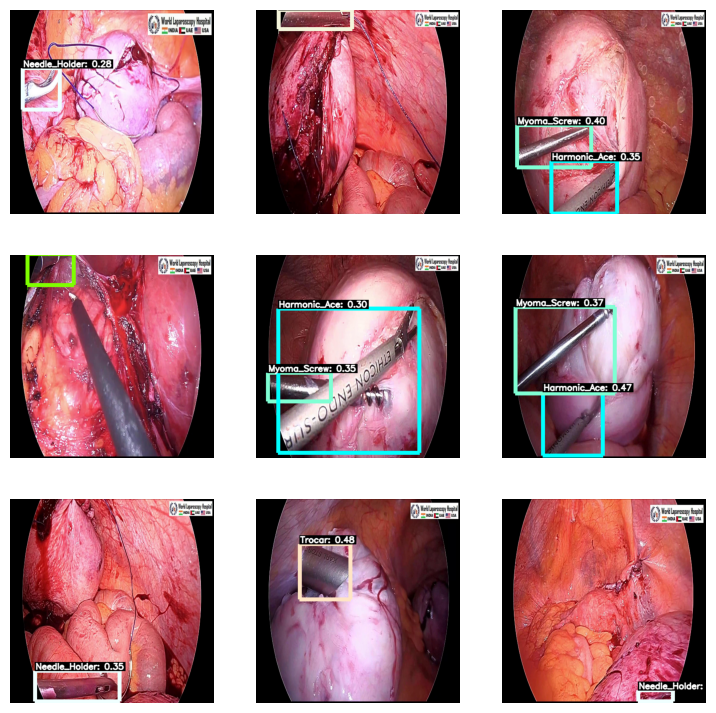

In [77]:
import os, random, cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
val_dir = "/kaggle/input/sis-det-val/valid"

min_score_thresh = 0.1
# visualization layout
N = 9
cols = 3
rows = int(np.ceil(N / cols))

# ---- MODEL DIMENSIONS FOR TFLITE INFERENCE ----
MODEL_H = 512   # TFLite model input height
MODEL_W = 512   # TFLite model input width

# ---------- LOAD TFLITE ----------
interpreter = tf.lite.Interpreter(
    model_path="/kaggle/working/SIS_TFOD_CenterNet_hg104.tflite"
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# ---- FIX MODEL INPUT SHAPE (ONCE) ----
interpreter.resize_tensor_input(
    input_details[0]["index"],
    [1, MODEL_H, MODEL_W, 3],
    strict=True
)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# random image selection
all_imgs = [os.path.join(val_dir, f)
            for f in os.listdir(val_dir)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))]

sample_imgs = random.sample(all_imgs, N)

# load images
raw_images = []
orig_images = []

for p in sample_imgs:
    img = cv2.imread(p)
    orig_images.append(img.copy())
    raw_images.append(np.array(img))

plt.figure(figsize=(3 * cols, 3 * rows))

for i, image in enumerate(raw_images):
    plt.subplot(3, 3, i+1)

    input_image = cv2.resize(image, (512, 512))
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    image_np = input_image.copy()

    # BGR → RGB
    # input_image = input_image[:, :, ::-1]
    input_image = np.expand_dims(input_image, 0).astype(np.uint8)

    interpreter.set_tensor(input_details[0]["index"], input_image)
    interpreter.invoke()

    # -------- get TFLite outputs --------
    tflite_outputs = [
        interpreter.get_tensor(o["index"]) for o in output_details
    ]

    # RAW outputs (before NMS)
    raw_scores = tflite_outputs[4][0]
    classes = tflite_outputs[2][0].astype(int)   
    
    raw_boxes   = tflite_outputs[1][0]

    # -------- CUSTOM NMS --------
    boxes, classes, scores = class_wise_nms_centernet(
        raw_boxes,
        classes,
        raw_scores,
        score_thresh=min_score_thresh,
        iou_thresh=0.3,
        max_detections_per_class=10
    )

    boxes, classes, scores = global_nms(
        boxes,
        classes,
        scores,
        iou_thresh=0.3,
        max_detections=10
    )
    # -------- visualize --------
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        boxes,
        classes,
        scores,
        category_index=category_index,
        use_normalized_coordinates=True,
        min_score_thresh=min_score_thresh,
        skip_labels=True,
        skip_scores=True,
        line_thickness=10
    )

    # draw big labels
    draw_labels_cv2(
        image_np,
        boxes,
        classes,
        scores,
        category_index,
        font_scale=0.7,
        thickness=2
    )

    plt.imshow(image_np)
    plt.axis("off")

plt.show()

---